In [1]:
import numpy as np
#cimport numpy as np
import h5py
import matplotlib.pyplot as plt
import MSMRD.trajectories.trajectoryTools as trajTools
import pickle
%matplotlib inline

In [2]:
def discreteHistogram(data):
    d = np.diff(np.unique(data)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    hist = plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
    centers = (hist[1][1:] + hist[1][:-1])/2
    return hist, centers

In [104]:
%%time
numfiles = 6
# Extract trajectories from file using asym2Dtraj class
fname = '../data/asym2D/box/2Dasym_B6_RT1E7_dt1E-4_SI10_SF2_'
samplingInterval = 10
dimension = 2
minima = np.array([[0.0,0.0], [1.0,0.0] , [1.1, 1.0], [-0.1,0.9], [-1.3,0.8], [-1.0,-0.2], [-0.6,-1.0], [0.9,-0.8], [0.2,-1.5]])
discretizer = trajTools.trajDiscretizationCython(minima, 2.5)
trajs = []
fullDTrajs = []
truncTrajs = []
dTruncTrajs = []
i = 0
for number in range(numfiles):
    f = h5py.File(fname + str(number) + '.h5', 'r')
    data = np.array(f['traj'], dtype=float)
    f.close()
    if not np.allclose(data[1:,0]-data[:-1,0], samplingInterval):
        print 'timestep not constant'
    traj = data[::1,1:dimension+1]
    fullDTrajs.append(discretizer.getdTrajs([traj]))
    lastTruncTrajs = discretizer.getTruncatedTraj(traj, prepend=True)
    truncTrajs += lastTruncTrajs
    dTruncTrajs += discretizer.getdTrajs(lastTruncTrajs)
    i+=1
    if i % 10 == 0:
        print str(i/float(numfiles) * 100)+'% done'
    # delete memory to avoid overhead
    del data
    del traj

CPU times: user 1min 49s, sys: 224 ms, total: 1min 49s
Wall time: 1min 49s


In [105]:
%%time
entryTrajsStart, entryTrajsEnd, entryTimes = discretizer.getLookupTableEntry(dTruncTrajs, truncTrajs)

CPU times: user 196 ms, sys: 0 ns, total: 196 ms
Wall time: 199 ms


In [106]:
%%time
exitPositions, exitTimes = discretizer.getLookupTableExit(dTruncTrajs, truncTrajs)

CPU times: user 140 ms, sys: 0 ns, total: 140 ms
Wall time: 149 ms


In [107]:
%%time
transitionTrajs = discretizer.getTransitionTrajs(dTruncTrajs)

CPU times: user 168 ms, sys: 4 ms, total: 172 ms
Wall time: 180 ms


593
1394
3242
2113
2866
2057
1732
1788
2868


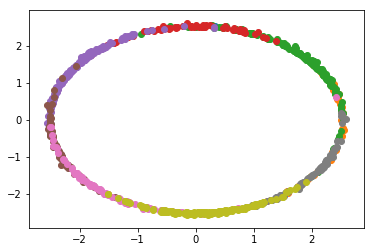

In [94]:
for i in range(9):
    plt.scatter(np.array(exitPositions[i])[:,0], np.array(exitPositions[i])[:,1])
for i in range(9):
    print np.amax(exitTimes[i])

In [15]:
exitPositions[0]

[array([-1.65488195, -1.88684022]), array([ 0.3368195 ,  2.51937914])]

qqqaplt.scatter(entryTrajsStart[:,0], entryTrajsStart[:,1])
plt.scatter(minima[:,0], minima[:,1])

In [66]:
angles = np.arctan2(entryTrajsStart[:,1], entryTrajsStart[:,0]) + np.pi
NangularPartitions = 60
angularMap = []
sortedEntryTrajsStart = []
sortedEntryTrajsEnd = []
sortedEntryTimes = []
for i in range(NangularPartitions):
    angularIncrement = 2*np.pi/NangularPartitions
    idcs = np.where(np.logical_and(angles>i*angularIncrement, angles<= (i+1)*angularIncrement))[0]
    sortedEntryTrajsStart.append(entryTrajsStart[idcs])
    sortedEntryTimes.append(entryTimes[idcs])
    sortedEnds = []
    for j in idcs:
        sortedEnds.append(entryTrajsEnd[j])
    sortedEntryTrajsEnd.append(sortedEnds)

In [67]:
exitProbs = np.zeros(9)
for i in range(9):
    outgoingTrajs = 0
    for j in range(10):
        outgoingTrajs += len(transitionTrajs[i][j])   
    exitProbs[i] = len(transitionTrajs[i][9])/float(outgoingTrajs)
print exitProbs

[ 0.00264901  0.04594595  0.24009901  0.0695825   0.23244552  0.05154639
  0.07917889  0.067659    0.16984127]


In [48]:
exitProbs[0] = 0.

In [49]:
print exitProbs

[ 0.          0.0498008   0.24041812  0.06395349  0.23928571  0.05777778
  0.07142857  0.06365503  0.17486339]


In [50]:
#resolve problem that fullDTrajs is a list of lists
trajectories = []
for traj in fullDTrajs:
    trajectories.append(traj[0])

In [51]:
#put all exit trajs into one list, from the list sorted by state
exitTrajs = []
for i in range(9):
    exitTrajs += (transitionTrajs[i][9])

In [68]:
import pyemma
import pyemma.plots as mplt
import pyemma.msm
import msmtools.estimation as est
#its = pyemma.msm.its(trajectories,  lags = 500, reversible=True)

In [80]:
def implied_timescales(lag):
    fullCount = est.count_matrix(trajectories, lag)
    exitCounts = est.count_matrix(exitTrajs, lag)
    finalCountMatrix = 1. * fullCount
    for i in range(9):
        finalCountMatrix[i,i] -= exitCounts[i,i]
    tmatrixFull = est.transition_matrix(fullCount)
    tmatrix = est.transition_matrix(finalCountMatrix).todense()
    treduced = np.copy(tmatrix[:9,:9])
    for i in range(9):
        treduced[i,:] /= np.sum(treduced[i,:])
    MSM = pyemma.msm.markov_model(treduced)
    return MSM.timescales()

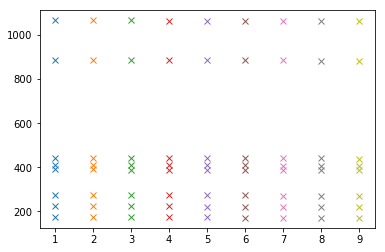

In [82]:
for lag in range(1, 10):
    timescales = implied_timescales(lag)
    plt.plot([lag]*len(timescales), lag*timescales, 'x')

In [73]:
MSM()

array([ 11.42341551,  10.17707013,   8.88320009,   6.53354375,
         4.99762789,   4.67724187,   4.24471682,   3.94548728,   3.59413123])

In [95]:
fullCount = est.count_matrix(trajectories, 50)

In [96]:
exitCounts = est.count_matrix(exitTrajs, 50)

In [97]:
for i in range(9):
    print exitCounts[i,i]/fullCount[i,i]

0.00598912252253
0.0925332232479
0.266913532439
0.109432286796
0.223187687697
0.0804390611689
0.0978062552422
0.0735241517564
0.171015719188


In [98]:
finalCountMatrix = 1. * fullCount
for i in range(9):
    finalCountMatrix[i,i] -= exitCounts[i,i]

In [99]:
tmatrix = est.transition_matrix(finalCountMatrix).todense()
treduced = np.copy(tmatrix[:9,:9])
for i in range(9):
    treduced[i,:] /= np.sum(treduced[i,:])
for i in range(9):
    print (treduced[i,i])

0.873591137232
0.816340075853
0.893456565557
0.892326565828
0.9232233138
0.898567642303
0.8418742385
0.832922032276
0.903938769577


In [100]:
tmatrixFull = est.transition_matrix(fullCount).todense()
treducedFull = np.copy(tmatrixFull[:9,:9])
for i in range(9):
    treducedFull[i,:] /= np.sum(treducedFull[i,:])
for i in range(9):
    print (treducedFull[i,i])

0.874253015103
0.830453335278
0.919608279546
0.902966171191
0.939319120919
0.905959477681
0.8550989323
0.843281121765
0.919036686252


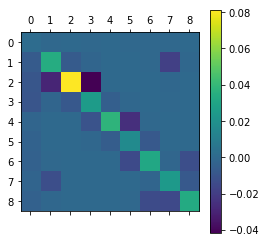

In [37]:
plt.matshow(treducedFull - treduced)
plt.colorbar()

(array([ -200.,     0.,   200.,   400.,   600.,   800.,  1000.,  1200.,
         1400.]), <a list of 9 Text yticklabel objects>)

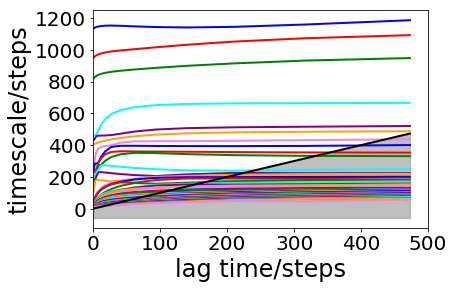

In [15]:
# Plot implied time scales
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2, dt=1)
plt.ylabel(r"timescale/steps", fontsize = 24)
plt.xlabel(r"lag time/steps", fontsize = 24)
#plt.xlim(0,900)
#plt.ylim(-100,1700)
plt.xlim(0,500)
#plt.ylim(100,10000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [59]:
MSMlag = 5
M = pyemma.msm.estimate_markov_model(trajectories, lag=MSMlag)

In [60]:
for i in range(9):
    print np.sum(M.transition_matrix[i,i])

0.863827210685
0.872027106752
0.893216625959
0.897019711975
0.891811246805
0.883133662158
0.877794600941
0.874683419402
0.874752038021


In [32]:
print exitProbs

[ 0.0083739   0.09462091  0.36266294  0.1334709   0.39065798  0.12092372
  0.15430996  0.15595945  0.30740886]


In [61]:
# truncate transition matrix such that only transitions withing the inner states are allowed
Tmatrix= np.copy(M.transition_matrix[:9,:9])
for i in range(9):
    Tmatrix[i,:] /= np.sum(Tmatrix[i,:])
for i in range(9):
    print Tmatrix[i,i]

0.869488711922
0.895468792834
0.943177051203
0.920511397019
0.944797075291
0.908065748468
0.908460330621
0.906657155534
0.924231556116


In [101]:
#Prepare data to be extracted to file
#For this we need the position of the cluster centers as well as the information about the angles of the exit states
class truncTrajsModel(object):    
    def __init__(self, entryTrajsStart, entryTrajsEnd, entryTimes, exitTrajs, exitTimes, exitProbs, MSMtime, tmatrix, NangularBins):
        self.entryTrajsStart = entryTrajsStart
        self.entryTrajsEnd = entryTrajsEnd
        self.entryTimes = entryTimes
        self.exitTrajs = exitTrajs
        self.exitTimes = exitTimes
        self.exitProbs = exitProbs
        self.tmatrix = tmatrix
        self.MSMtimestep = MSMtime
        self.NangularBins = NangularBins

In [102]:
model = truncTrajsModel(sortedEntryTrajsStart, sortedEntryTrajsEnd, sortedEntryTimes, exitPositions, exitTimes, exitProbs, 0.05, treduced, NangularPartitions)

In [103]:
pickle.dump(model, open('../data/models/asym2D/periodicModel_lag50_60partitions_SF2_exitCompensation_5files.p', 'wa'))